# GPU in colab
First, you'll need to enable GPUs for the notebook:
*   Navigate to Edit→Notebook Settings
*   select GPU from the Hardware Accelerator drop-down




In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
from google.colab import drive, files
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Importing Data

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape # checking data shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [ ]:
numb_cats = y_train.max() + 1 # number of different categories

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, numb_cats) # converting to vector of probabilities
y_test =  tf.keras.utils.to_categorical(y_test, numb_cats)

In [ ]:
X_train.max(), X_train.min() # checking if images are rescaled

(255, 0)

# Preprocessing data via Keras Tools

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255, # rescaling 
    featurewise_center=True, # if True it sets the mean to 0
    featurewise_std_normalization=True, # if True sets stdev to 1
    validation_split=0.2# float fraction of images for validation
    )

# other patemeters of ImageDataGenerator are found here:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

BATCH_SIZE = 32 # mini batch size

datagen.fit(X_train) # preprocessing data by applying the generator to our train dataset
datagen.fit(X_test) # applying the generator to our train dataset




In [ ]:

# Creating Training, Validation and Test Data set as generators
# Generator allow you to declare a function that behaves like an iterator (e.g. list)
# Generators are memory-efficient ways of processing huge datasets (much more efficient than lists, arrays)

train_generator = datagen.flow(
    X_train, # Selecting X train
    y_train, # Selecting target
    batch_size=BATCH_SIZE, # Specifying the size of mini-batch
    shuffle=True, # if True it shuffles the data randomly
    subset='training' # Picks the training subset of the data 
    #so 1 - validation_split fraction of dataset
    )

val_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation'
    )

test_generator =  datagen.flow(
    X_test,
    y_test,
    batch_size=1 # with test data batch size should be 1
    )

# Model of a network

In [ ]:
input_shape = X_train.shape[1:]
input_shape

(32, 32, 3)

In [ ]:
model = tf.keras.Sequential()
## MAGIC LAYERS will be explained in Session 2 ##############   
### We call them MAGIC as they will improve our predictions #
### These layers will be properly explained in Session 2 ####
# convolutional layer 1
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=input_shape)
)
# convolutional layer 2
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    activation='relu')
)
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # this performs downsampling 
## END OF MAGIC ####################################

model.add(tf.keras.layers.Flatten()) # flattening 
model.add(tf.keras.layers.Dense(512, activation="relu")) # 1 hidden layer
model.add(tf.keras.layers.Dropout(0.5)) # This is new, Dropout layer prevents overfitting
# Dropout is a technique where randomly selected neurons are ignored during training
model.add(tf.keras.layers.Dense(numb_cats, activation='softmax')) # output layer

## Callbacks

In [ ]:
# saving best model

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", 
    monitor = "val_accuracy", 
    verbose = 1, 
    save_best_only = True,
    mode = 'max'
    )


In [ ]:
# early stopping - prevents overstopping, lr_scheduler, tensorboard_callback]fitting
# it stops the training if your model stops improving for specified number of epochs
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # we monitor the loss for the validation 
    min_delta=0, # minimum change in the monitored quantity to qualify as an improvement
    patience=5, # Number of epochs with no improvement after which training will be stopped.
    verbose=1, # how verbal the description should be
    mode='min', # In min mode, training will stop when the quantity monitored has stopped decreasing
    baseline=None, # Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
    restore_best_weights=False # Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
)



In [ ]:
# At the beginning of every epoch, 
# this callback gets the updated learning rate value 
# from scheduler function 

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# TensorBoard is a visualization tool provided with TensorFlow.
# This callback logs events for TensorBoard, including:
# Metrics summary plots
# Training graph visualization
# Weight histograms
# Sampled profiling

logdir = "../logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
# collecting all callbacks together

callbacks_list = [checkpoint, earlystopping, lr_scheduler, tensorboard_callback]

# Optimizer & Compliing the model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# Training the model

In [ ]:
EPOCHS = 10

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.n // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list
    )

Epoch 1/10
1246/1250 [============================>.] - ETA: 0s - loss: 1.5964 - accuracy: 0.4317
Epoch 1: val_accuracy improved from -inf to 0.54327, saving model to model.h5
1250/1250 [==============================] - 27s 14ms/step - loss: 1.5955 - accuracy: 0.4321 - val_loss: 1.2855 - val_accuracy: 0.5433 - lr: 1.0000e-04
Epoch 2/10
1248/1250 [============================>.] - ETA: 0s - loss: 1.2317 - accuracy: 0.5654
Epoch 2: val_accuracy improved from 0.54327 to 0.59605, saving model to model.h5
1250/1250 [==============================] - 17s 14ms/step - loss: 1.2318 - accuracy: 0.5653 - val_loss: 1.1287 - val_accuracy: 0.5961 - lr: 1.0000e-04
Epoch 3/10
1249/1250 [============================>.] - ETA: 0s - loss: 1.0577 - accuracy: 0.6308
Epoch 3: val_accuracy improved from 0.59605 to 0.64163, saving model to model.h5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0577 - accuracy: 0.6308 - val_loss: 1.0060 - val_accuracy: 0.6416 - lr: 1.0000e-04
Epoch 4/10

## Model summary

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               3211776   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

# Visualising loss and accuracy curves by MATPLOTLIB

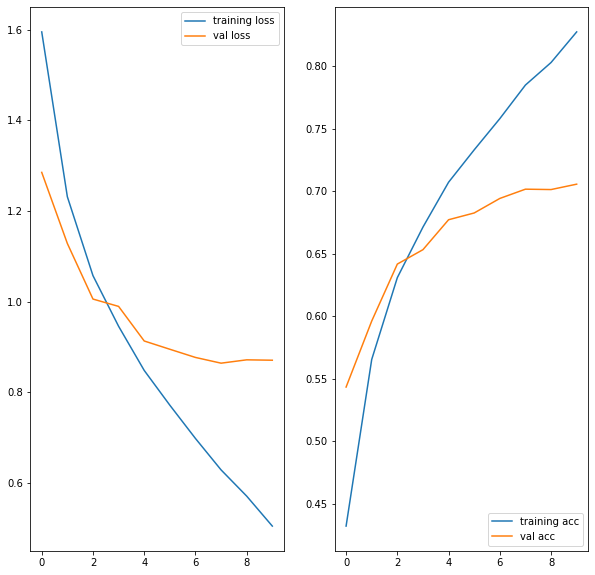

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="training acc")
plt.plot(history.history['val_accuracy'], label="val acc")
plt.legend(loc='lower right')

plt.show()

# Viewing TENSORBOARD

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ../logs/scalars

## Loading BEST WEIGHTS

In [ ]:
# loading the best weights
model.load_weights("model.h5")

# Evaluating the model on unseen TEST DATA

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}, test loss: {test_loss}') # we reached 70% in CIFAR10 it is almost 20% improvement after adding the magic layers

10000/10000 [==============================] - 42s 4ms/step - loss: 0.8801 - accuracy: 0.7024
Test accuracy: 0.7024000287055969, test loss: 0.880064070224762
